In [1]:
#%%nbtemplate init
# Prepare nbtemplate magics (use %%nbtemplate for jinja-assisted evaluation)
from app import nbtemplate
nbtemplate.init(lambda _=globals: _())

# Imputing Knowledge about Gene and Protein Function with Machine Learning

In [2]:
%matplotlib inline
# Imports
## Data processing
import pandas as pd
import numpy as np
import scipy as sp
## Machine Learning
import sklearn as sk
from sklearn import (
    calibration,
    decomposition,
    ensemble,
    feature_selection,
    linear_model,
    manifold,
    metrics,
    model_selection,
    multioutput,
    pipeline,
    preprocessing,
    svm,
    tree,
)
## Plotting
from matplotlib import pyplot as plt
## Harmonizome API
from harmonizome import Harmonizome
## Utility
import re
import json
from functools import reduce
from IPython.display import display

In [3]:
# Utility functions

def try_json_loads(s):
    try:
        return json.loads(s)
    except:
        return ''

## Create custom "randfloat" that behaves like randint but for floats
from scipy.stats import uniform, randint
def randfloat(start, end):
    ''' Utility function for generating a float uniform distribution '''
    return uniform(start, end - start)

# reproducable random seed
rng = 2018

In [6]:
%%nbtemplate hide
{% do SectionField(
    title='ATTRIBUTE AND PREDICTION CLASS DATASET SELECTION',
    subtitle='Select the datasets to use for learning and classification.',
    group='DATASETS',
) %}
{% set attribute_datsets = MultiChoiceField(
    name='attribute_datasets',
    label='Attribute Selection (place cursor inside the box to add more datasets)',
    hint='Databases to use for prediction',
    description='The selected datasets will be concatenated and used to train the model.',
    default=[
        'CCLE Cell Line Gene Expression Profiles',
        'ENCODE Transcription Factor Targets',
    ],
    choices=[
        'CCLE Cell Line Gene Expression Profiles',
        'ENCODE Transcription Factor Targets',
        'Allen Brain Atlas Adult Human Brain Tissue Gene Expression Profiles',
        'CHEA Transcription Factor Targets',
        'BioGPS Cell Line Gene Expression Profiles',
        'GTEx Tissue Gene Expression Profiles',
    ],
    group='DATASETS',
) %}
{% set target = TargetField(
    name='target',
    label='Target Selection',
    default='Class',
    choices={
        'Class': TargetClassSearchField(
            name='target_class',
            label='Class',
            default='cancer (DOID:162 from DISEASES Text-mining Gene-Disease Assocation Evidence Scores)',
            hints=[
                'cancer',
                'lung',
                'heart',
                'tumor',
            ],
        ),
        'Gene': TargetGeneSearchField(
            name='target_gene',
            label='Gene',
            default='STAT3 (DOID:162 from DISEASES Text-mining Gene-Disease Assocation Evidence Scores)',
            hints=[
                'STAT3',
            ],
        ),
    },
    group='DATASETS',
) %}
{% set target_label, target_group, target_dataset = target|re_match('^(.+) \\((.+) from (.+)\\)$') %}
{% set target_name = (target_label + ' ' + target_group).strip() %}

## Inputs

Given a target attribute of interest, we will use machine learning to predict genes that are strongly correlated with that target. Using the Harmonizome data query API, we download the dataset containing the target attribute as well as a number of well-populated Omics datasets for more genes and features and build a large sparse dataframe.

Select Omics datasets are downloaded and joined on the Gene producing a large association matrix. Only association is preserved in order to create a binary classification task.

In [7]:
%%nbtemplate code_eval
attribute_datasets = {{ attribute_datsets }}

df_attributes = list(Harmonizome.download_df(
    [dataset
     for dataset in attribute_datasets],
    ['gene_attribute_matrix.txt.gz'],
))
for name, df in zip(attribute_datasets, df_attributes):
    df.index.name = json.loads(df.index.name)[0]
    df.index = df.index.map(lambda s: json.loads(s)[0])
    df.columns = df.columns.map(lambda s: ' '.join(ss for ss in try_json_loads(s) if ss != 'na'))
    print('%s shape:' % (name), df.shape)
    display(df.head())

# Assemble all attribute datasets
if len(df_attributes) > 1:
    # Obtain merged dataframe with omics and target data
    df = reduce(
        lambda a, b: pd.merge( # Merge two dataframes item by item
            a, # left
            b, # right
            # Items with the same left and right index are merged
            left_index=True,
            right_index=True,
            how='outer', # Keep mis-matched index
        ),
        df_attributes,
    )
else:
    df = df_attributes[0]

X = df.applymap(lambda f: 1 if f!=0 else 0)
print('Total Shape:', X.shape)
display(X.head())

```python
attribute_datasets = ['CCLE Cell Line Gene Expression Profiles', 'ENCODE Transcription Factor Targets']
df_attributes = list(Harmonizome.download_df(
    [dataset
     for dataset in attribute_datasets],
    ['gene_attribute_matrix.txt.gz'],
))
for name, df in zip(attribute_datasets, df_attributes):
    df.index.name = json.loads(df.index.name)[0]
    df.index = df.index.map(lambda s: json.loads(s)[0])
    df.columns = df.columns.map(lambda s: ' '.join(ss for ss in try_json_loads(s) if ss != 'na'))
    print('%s shape:' % (name), df.shape)
    display(df.head())
# Assemble all attribute datasets
if len(df_attributes) > 1:
    # Obtain merged dataframe with omics and target data
    df = reduce(
        lambda a, b: pd.merge( # Merge two dataframes item by item
            a, # left
            b, # right
            # Items with the same left and right index are merged
            left_index=True,
            right_index=True,
            how='outer', # Keep mis-matched index
        ),
        df_attributes,
    )
else:
    df = df_attributes[0]
X = df.applymap(lambda f: 1 if f!=0 else 0)
print('Total Shape:', X.shape)
display(X.head())
```

CCLE Cell Line Gene Expression Profiles shape: (18025, 1037)


,CHL1 skin,HMCB skin,HS852T skin,HS695T skin,A101D skin,HS294T skin,SNU466 central nervous system,SKMEL31 skin,SKMEL24 skin,WM115 skin,...,HEL9217 haematopoietic and lymphoid tissue,HEL haematopoietic and lymphoid tissue,UT7 haematopoietic and lymphoid tissue,SET2 haematopoietic and lymphoid tissue,MOLM16 haematopoietic and lymphoid tissue,KU812 haematopoietic and lymphoid tissue,TF1 haematopoietic and lymphoid tissue,MEG01 haematopoietic and lymphoid tissue,KYO1 haematopoietic and lymphoid tissue,K562 haematopoietic and lymphoid tissue
GeneSym,,,,,,,,,,,,,,,,,,,,,
FBN1,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0
ITGBL1,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
LRP1,-0.0,-0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
LTBP2,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0
PARVA,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


ENCODE Transcription Factor Targets shape: (22819, 181)


,ARID3A 1820,ATF1 466,ATF2 1386,ATF3 467,BACH1 571,BATF 10538,BCL11A 53335,BCL3 602,BCLAF1 9774,BDP1 55814,...,ZC3H11A 9877,ZEB1 6935,ZKSCAN1 7586,ZMIZ1 57178,ZNF143 7702,ZNF217 7764,ZNF263 10127,ZNF274 10782,ZNF384 171017,ZZZ3 26009
GeneSym,,,,,,,,,,,,,,,,,,,,,
A1BG,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BG-AS1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2ML1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


Total Shape: (23364, 1218)


,CHL1 skin,HMCB skin,HS852T skin,HS695T skin,A101D skin,HS294T skin,SNU466 central nervous system,SKMEL31 skin,SKMEL24 skin,WM115 skin,...,ZC3H11A 9877,ZEB1 6935,ZKSCAN1 7586,ZMIZ1 57178,ZNF143 7702,ZNF217 7764,ZNF263 10127,ZNF274 10782,ZNF384 171017,ZZZ3 26009
GeneSym,,,,,,,,,,,,,,,,,,,,,
A1BG,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
A1BG-AS1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2M,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
A2ML1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,1,0,0,1,0


We download the dataset containtaining the target.

In [8]:
%%nbtemplate
target_datasets = ['{{ target_dataset }}']

# Download attribute datasets from Harmonizome
df_targets = list(Harmonizome.download_df(
    [dataset
     for dataset in target_datasets],
    ['gene_attribute_matrix.txt.gz'],
))

for name, df in zip(target_datasets, df_targets):
    df.index.name = json.loads(df.index.name)[0]
    df.index = df.index.map(lambda s: json.loads(s)[0])
    df.columns = df.columns.map(lambda s: ' '.join(ss for ss in try_json_loads(s) if ss != 'na'))
    print('%s shape:' % (name), df.shape)
    display(df.head())

# Assemble all target datasets
if len(df_targets) > 1:
    # Obtain merged dataframe with omics and target data
    df = reduce(
        lambda a, b: pd.merge( # Merge two dataframes item by item
            a, # left
            b, # right
            # Items with the same left and right index are merged
            left_index=True,
            right_index=True,
            how='outer', # Keep mis-matched index
        ),
        df_targets,
    )
else:
    df = df_targets[0]

Y = df.applymap(lambda f: 1 if f!=0 else 0)
print('Total Shape:', Y.shape)
display(Y.head())

DISEASES Text-mining Gene-Disease Assocation Evidence Scores shape: (15309, 4628)


,integumentary system cancer DOID:0060122,skin cancer DOID:4159,skin carcinoma DOID:3451,basal cell carcinoma DOID:2513,keratoacanthoma DOID:3149,skin squamous cell carcinoma DOID:3151,actinic keratosis DOID:8866,seborrheic keratosis DOID:6498,verrucous carcinoma DOID:3737,infiltrative basal cell carcinoma DOID:4299,...,alternating exotropia DOID:1142,masters-allen syndrome DOID:14133,charcot-marie-tooth disease type 4 DOID:0050541,anal margin carcinoma DOID:4284,poland syndrome DOID:12961,cortical deafness DOID:0060140,form agnosia DOID:0060142,breast lipoma DOID:10199,queensland tick typhus DOID:10784,fatal infantile encephalocardiomyopathy DOID:0050713
GeneSym,,,,,,,,,,,,,,,,,,,,,
LRRTM4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZNF507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LRFN4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IMPA2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FAM174B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Total Shape: (15309, 4628)


,integumentary system cancer DOID:0060122,skin cancer DOID:4159,skin carcinoma DOID:3451,basal cell carcinoma DOID:2513,keratoacanthoma DOID:3149,skin squamous cell carcinoma DOID:3151,actinic keratosis DOID:8866,seborrheic keratosis DOID:6498,verrucous carcinoma DOID:3737,infiltrative basal cell carcinoma DOID:4299,...,alternating exotropia DOID:1142,masters-allen syndrome DOID:14133,charcot-marie-tooth disease type 4 DOID:0050541,anal margin carcinoma DOID:4284,poland syndrome DOID:12961,cortical deafness DOID:0060140,form agnosia DOID:0060142,breast lipoma DOID:10199,queensland tick typhus DOID:10784,fatal infantile encephalocardiomyopathy DOID:0050713
GeneSym,,,,,,,,,,,,,,,,,,,,,
LRRTM4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZNF507,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LRFN4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IMPA2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM174B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
%%nbtemplate markdown
{% if target.value == 'Gene' %}
For each class in the dataset, we build a list (1 if gene is associated, otherwise 0) building a matrix of gene lists to predict. We remove irrelevant classes (less than 10 available associations).
{% elif target.value == 'Class' %}
For the target class, we build a list (1 if gene is associated, otherwise 0)
{% endif %}

For the target class, we build a list (1 if gene is associated, otherwise 0)

In [25]:
%%nbtemplate
{% if target.value == 'Gene' %}
y = pd.DataFrame(index=X.index, columns=Y.columns)
for yy in Y.columns:
    y.loc[:, yy] = np.in1d(X.index, Y[Y[yy] != 0].index).astype(np.int8)
y = y.loc[:, y.sum() > 10]

print('Known Targets: %d (%0.3f %%)' % (y.sum().sum(), 100*y.sum().sum()/np.product(y.shape)))
{% elif target.value == 'Class' %}
y = np.in1d(X.index, Y[Y['{{ target_name }}'] == 1].index).astype(np.int8)

print('Known Targets: %d (%0.3f %%)' % (y.sum(), 100*y.sum()/len(y)))
{% endif %}

Known Targets: 820947 (1.069 %)


We produce a target array containing 1 if the gene is associated and 0 otherwise.

In [26]:
# Output data shapes
print('Input shape:', X.shape)
print('Target shape:', y.shape)

Input shape: (23364, 1218)
Target shape: (23364, 3287)


In [27]:
%%nbtemplate
{% do SectionField(
    title='SETTINGS',
    subtitle='From here you can select the various available Machine Learning algorithms, their unique settings, and the methods to use to evaluate the classifier.',
    group='SETTINGS',
) %}
{% set dimensionality_reduction = ChoiceField(
    name='dimensionality_reduction',
    label='Dimensionality Reduction Algorithm',
    description='A dimensionality reduction algorithm should be selected to improve the quality of the classifier.',
    default='PCA',
    choices={
        'PCA': 'sk.decomposition.PCA(n_components=64)',
        'TruncatedSVD': 'sk.decomposition.TruncatedSVD(n_components=64)',
        'IncrementalPCA': 'sk.decomposition.IncrementalPCA(n_components=64)',
        'ICA': 'sk.decomposition.FastICA(n_components=64)',
        'SparsePCA': 'sk.decomposition.SparsePCA(n_components=64)',
    },
    group='SETTINGS'
) %}

In [28]:
%%nbtemplate markdown
## Dimensionality Reduction

We reduce the dimensionality of our omics feature space with {{ dimensionality_reduction.value }}.

## Dimensionality Reduction
We reduce the dimensionality of our omics feature space with PCA.

In [29]:
%%nbtemplate
{% if target.value == 'Class' %}
clf_dimensionality_reduction = {{ dimensionality_reduction }}
X_reduced = clf_dimensionality_reduction.fit_transform(X.values)
{% if dimensionality_reduction == 'PCA' %}
print('Explained variance:', np.sum(clf_dimensionality_reduction.explained_variance_))
{% endif %}
{% if tsne %}
# Perform TSNE for low dimensional visualization
tsne = sk.manifold.TSNE(n_components=2, random_state=rng)
X_transformed = tsne.fit_transform(X_reduced, y)
plt.scatter(
   X_transformed_tsne[:, 0],
   X_transformed_tsne[:, 1],
   c=y,
)
{% else %}
plt.title('Low dimension representation')
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=y,
)
plt.show()
{% endif %}
{% endif %}

In [30]:
%%nbtemplate hide
{% set feature_selection = ChoiceField(
    name='feature_selection',
    label='Machine Learning Feature Selection',
    default='None',
    choices={
        'None': 'None',
        'SelectFromLinearSVC': 'sk.feature_selection.SelectFromModel(sk.svm.LinearSVC(loss="squared_hinge", penalty="l1", dual=False))',
        'SelectFromExtraTrees': 'sk.feature_selection.SelectFromModel(sk.tree.ExtraTreesClassifier())',
        'SelectKBest': 'sk.feature_selection.SelectKBest("f_classif")',
        'SelectKBestChi2': 'sk.feature_selection.SelectKBest("chi2")',
        'SelectKBestMultiInfo': 'sk.feature_selection.SelectKBest("mutual_info_classif")',
    },
    group='SETTINGS'
) %}
{% set cv_algorithm = ChoiceField(
    name='cv_algorithm',
    label='Cross Validation Algorithm',
    default='StratifiedKFold',
    value='KFold',
    choices={
        'KFold': 'sk.model_selection.KFold',
        'GroupKFold': 'sk.model_selection.GroupKFold',
        'RepeatedKFold': 'sk.model_selection.RepeatedKFold',
        'StratifiedKFold': 'sk.model_selection.StratifiedKFold',
        'RepeatedStratifiedKFold': 'sk.model_selection.RepeatedStratifiedKFold',
    },
    group='SETTINGS',
) %}
{% set algorithm = ChoiceField(
    name='algorithm',
    label='Machine Learning Algorithm',
    default='RandomForestClassifier',
    description='A machine learning algorithm should be selected to construct the predictive model.',
    choices={
        'GradientBoostingClassifier': 'sk.ensemble.GradientBoostingClassifier()',
        'RandomForestClassifier': 'sk.ensemble.RandomForestClassifier()',
        'AdaBoostClassifier': 'sk.ensemble.AdaBoostClassifier()',
        'ExtraTreesClassifier': 'sk.tree.ExtraTreesClassifier()',
        'DecisionTreeClassifier': 'sk.tree.DecisionTreeClassifier()',
        'KNeighborsClassifier': 'sk.neighbors.KNeighborsClassifier()',
        'RadiusNeighborsClassifier': 'sk.neighbors.RadiusNeighborsClassifier()',
        'MLPClassifier': 'sk.neural_network.MLPClassifier()',
        'OneClassSVM': 'sk.svm.OneClassSVM()',
    },
    group='SETTINGS'
) %}
{% set calibrated = BoolField(
    name='calibrated',
    label='Calibrate algorithm predictions',
    description='Calibrate the prediction probabilities eliminating model-imparted bias.',
    default=True,
    group='SETTINGS',
) %}
{% set hyper_param_search = ChoiceField(
    name='hyper_param_search',
    label='Hyper Parameter Search Type',
    default='None',
    description='Hyper parameter searching is used to automatically select the best parameters (using the primary metric as the criteria).',
    choices={
        'None': 'None',
        'RandomizedSearchCV': 'sk.model_selection.RandomizedSearchCV',
        'GridSearchCV': 'sk.model_selection.GridSearchCV',
    },
    group='SETTINGS'
) %}
{% set cross_validation_n_folds = IntField(
    name='cross_validation_n_folds',
    label='Cross-Validated Folds',
    description='Cross validation is employed as a strategy to train the model on data that the model has not seen before, more folds will ensure that the model is generalizing well.',
    default=3,
    min=2,
    max=10,
    group='SETTINGS'
) %}
{% set primary_metric = ChoiceField(
    name='primary_metric',
    label='Primary Evaluation Metric',
    default='roc_auc',
    description='The primary evaluation metric is used for deciding how we assess the performance of our model.',
    choices=[
        'explained_variance',
        'r2',
        'neg_median_absolute_error',
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_mean_squared_log_error',
        'median_absolute_error',
        'mean_absolute_error',
        'mean_squared_error',
        'accuracy',
        'roc_auc',
        'average_precision',
        'log_loss',
        'neg_log_loss',
        'adjusted_rand_score',
        'homogeneity_score',
        'completeness_score',
        'v_measure_score',
        'mutual_info_score',
        'adjusted_mutual_info_score',
        'normalized_mutual_info_score',
        'fowlkes_mallows_score',
        'precision',
        'precision_macro',
        'precision_micro',
        'precision_samples',
        'precision_weighted',
        'recall',
        'recall_macro',
        'recall_micro',
        'recall_samples',
        'recall_weighted',
        'f1',
        'f1_macro',
        'f1_micro',
        'f1_samples',
        'f1_weighted'
    ],
    group='SETTINGS'
) %}
{% set evaluation_metrics = MultiChoiceField(
    name='evaluation_metrics',
    label='Evaluation Metrics',
    default=[],
    description='Additional evaluation metrics can be specified, these metrics will also be reported for all models trained.',
    value=['recall', 'f1'],
    choices=[
        'explained_variance',
        'r2',
        'neg_median_absolute_error',
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_mean_squared_log_error',
        'median_absolute_error',
        'mean_absolute_error',
        'mean_squared_error',
        'accuracy',
        'roc_auc',
        'average_precision',
        'log_loss',
        'neg_log_loss',
        'adjusted_rand_score',
        'homogeneity_score',
        'completeness_score',
        'v_measure_score',
        'mutual_info_score',
        'adjusted_mutual_info_score',
        'normalized_mutual_info_score',
        'fowlkes_mallows_score',
        'precision',
        'precision_macro',
        'precision_micro',
        'precision_samples',
        'precision_weighted',
        'recall',
        'recall_macro',
        'recall_micro',
        'recall_samples',
        'recall_weighted',
        'f1',
        'f1_macro',
        'f1_micro',
        'f1_samples',
        'f1_weighted'
    ],
    group='SETTINGS',
) %}
{% set all_metrics = [primary_metric.value] + evaluation_metrics.value %}

In [14]:
%%nbtemplate markdown
## Machine Learning

We apply a {% if hyper_param_search.value != 'None' %}{{ hyper_param_search.value }} search for the hyper parameters
of a {% endif %}sklearn pipeline with a dimensionality reduction step of {{ dimensionality_reduction.value }}
{% if feature_selection.value != 'None' %}and a feature selection step of {{ feature_selection.value }}
{% endif %} and a{% if calibrated %} calibrated{%endif %} {{ algorithm.value }} classifier
using {{ cross_validation_n_folds.value }}-fold repeated
stratified cross-validation, optimizing {{ primary_metric.value }}
{% if evaluation_metrics.value %} and computing {{ ', '.join(evaluation_metrics.value) }}{% endif %}.

## Machine Learning
We apply a sklearn pipeline with a dimensionality reduction step of PCA
 and a calibrated RandomForestClassifier classifier
using 3-fold repeated
stratified cross-validation, optimizing roc_auc
 and computing recall, f1.

In [15]:
%%nbtemplate
{% if algorithm.value == 'GradientBoostingClassifier' %}
## Early stopping function
def early_stopping(n_rounds, tol=0.001):
    def early_stopping_func(i, self, local):
        rounds = getattr(self, '__rounds', 0)
        last = getattr(self, '__last', None)
        current = self.train_score_[i]
        if last and current and abs(current - last) < tol:
            rounds += 1
            if rounds > n_rounds:
                return True
        else:
            rounds = 0
        setattr(self, '__last', current)
        setattr(self, '__rounds', rounds)
        return False
    return early_stopping_func
{% endif %}

{#
param_grid = {
    'reduce_dim__n_components': randint(2, 1024),
{% if algorithm.value == 'GradientBoostingClassifier' %}
    'clf__loss': ['deviance', 'exponential'],
    'clf__learning_rate': randfloat(0.001, 1.),
    'clf__subsample': randfloat(0.01, 1.),
{% elif algorithm.value == 'RandomForestClassifier' %}
    'clf__oob_score': [True],
    'clf__criterion': ['gini', 'entropy'],
{% endif %}
    'clf__n_estimators': randint(10, 200),
    'clf__max_depth': randint(20, 50),
    'clf__max_features': ['sqrt', 'log2', None],
    'clf__min_impurity_decrease': randfloat(0., 0.2),
    'clf__min_weight_fraction_leaf': randfloat(0., 0.5),
}

fit_params = {
{% if algorithm.value == 'GradientBoostingClassifier' %}
    'clf__monitor': early_stopping(5),
{% endif %}
}
#}
    
cv = {{ cv_algorithm }}(
    n_splits={{ cross_validation_n_folds }},
    shuffle=True,
    random_state=rng,
)

model =
{%- if hyper_param_search.value != 'None' %} {{ hyper_param_search }}({% endif -%}
{%- if target.value == 'Gene' %} multioutput.MultiOutputClassifier({% endif -%}
    {%- if calibrated %} sk.calibration.CalibratedClassifierCV({% endif -%}
        sk.pipeline.Pipeline([
            ('reduce_dim', {{ dimensionality_reduction }}),
            {%- if feature_selection.value != 'None' %}('feature_selection', {{ feature_selection }}),{% endif %}
            ('clf', {{ algorithm }}),
        ]),
    cv=cv,
{% if calibrated %}){% endif -%}{% if target_type == 'Gene' %}){% endif %}{%- if hyper_param_search.value != 'None' %}){% endif %}

# Scoring parameters
primary_metric = '{{ primary_metric }}'
evaluation_metrics = {{ evaluation_metrics }}
scoring_params = {k: v
                  for k,v in metrics.scorer.SCORERS.items()
                  if k == primary_metric or k in evaluation_metrics}

In [16]:
%%nbtemplate code_eval
{% if hyper_param_search.value == 'None' %}
df_results = pd.DataFrame()
for fold, (train, test) in enumerate(cv.split(X.values, y)):
    model.fit(X.values[train], y[train])
    {% for metric in all_metrics %}
    {% if target.value == 'Class' %}
    df_results.loc[fold, '{{ metric }}'] = scoring_params['{{ metric }}'](model, X.values[test], y[test])
    {% elif target.value == 'Gene' %}
    df_results.loc[fold, '{{ metric }}', y.columns] = scoring_params['{{ metric }}'](model, X.values[test], y[test])
    {% endif %}
    {% endfor %}
display(df_results.agg(['mean', 'std']))
{% else %}
model.fit(X, y)
df_results = model.cv_results_
{% endif %}

```python
df_results = pd.DataFrame()
for fold, (train, test) in enumerate(cv.split(X.values, y)):
    model.fit(X.values[train], y[train])
    df_results.loc[fold, 'roc_auc'] = scoring_params['roc_auc'](model, X.values[test], y[test])
    df_results.loc[fold, 'recall'] = scoring_params['recall'](model, X.values[test], y[test])
    df_results.loc[fold, 'f1'] = scoring_params['f1'](model, X.values[test], y[test])
display(df_results.agg(['mean', 'std']))
```

,roc_auc,recall,f1
mean,0.718323,0.683411,0.652720
std,0.006494,0.006145,0.005275


This visualization shows illustrates the cross-validated performance of the model. Low fold variance and high AUC is desired in a well-generalized model.

```python
fig, ax = plt.subplots()
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for fold, (train, test) in enumerate(cv.split(X.values, y)):
    model.fit(X.values[train], y[train])
    y_proba = model.predict_proba(X.values[test]) # Probability prediction will be True
    fpr, tpr, _ = sk.metrics.roc_curve(y[test], y_proba[:, 1])
    tprs.append(sp.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = sk.metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    ax.plot(fpr, tpr, alpha=0.4, label='ROC Fold %d (AUC=%0.3f)' % (fold, roc_auc))
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = sk.metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)
ax.plot([0,1],[0,1],'--', label='Luck')
ax.legend()
z = (mean_auc - 0.5)/std_auc
cl = sp.stats.norm.cdf(z) * 100
ci = sp.stats.norm.interval(0.95, loc=mean_auc, scale=std_auc)
print('Confidence interval (95%)', ci)
print("We are %0.3f %% confident the model's results are not just chance." % (cl))
if cl > 95:
    print('This is statistically significant. These results can be trusted.')
else:
    print('This is not statistically significant. These results should not be trusted.')
```

Confidence interval (95%) (0.7121216520635377, 0.7285538838589122)
We are 100.000 % confident the model's results are not just chance.
This is statistically significant. These results can be trusted.


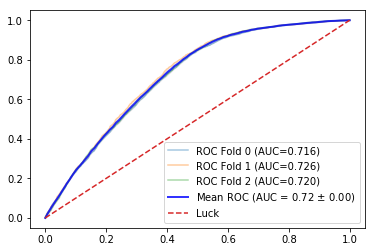

In [17]:
%%nbtemplate code_eval
{% if 'roc_auc' in all_metrics %}
fig, ax = plt.subplots()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for fold, (train, test) in enumerate(cv.split(X.values, y)):
    model.fit(X.values[train], y[train])
    y_proba = model.predict_proba(X.values[test]) # Probability prediction will be True
    fpr, tpr, _ = sk.metrics.roc_curve(y[test], y_proba[:, 1])
    tprs.append(sp.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = sk.metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    ax.plot(fpr, tpr, alpha=0.4, label='ROC Fold %d (AUC=%0.3f)' % (fold, roc_auc))

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = sk.metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

ax.plot([0,1],[0,1],'--', label='Luck')
ax.legend()

z = (mean_auc - 0.5)/std_auc
cl = sp.stats.norm.cdf(z) * 100
ci = sp.stats.norm.interval(0.95, loc=mean_auc, scale=std_auc)
print('Confidence interval (95%)', ci)
print("We are %0.3f %% confident the model's results are not just chance." % (cl))
if cl > 95:
    print('This is statistically significant. These results can be trusted.')
else:
    print('This is not statistically significant. These results should not be trusted.')
{% endif %}

This will take a long time as we are evaluating n_iter different models n_splits different times each computing all the metrics on `product(X.shape)` data points--not to mention the size of each model dictated by the range of parameters specified in the params dict.

In [18]:
cm = metrics.confusion_matrix(y, model.predict(X.values))
display(cm)
print('\n',
    'True labels predicted to be true:', cm[0,0], '\n',
    'True labels predicted to be false:', cm[0,1], '\n',
    'False labels predicted to be true:', cm[1,0], '\n',
    'False labels predicted to be false:', cm[1,1])

array([[10542,  1737],
       [ 1395,  9690]])


 True labels predicted to be true: 10542 
 True labels predicted to be false: 1737 
 False labels predicted to be true: 1395 
 False labels predicted to be false: 9690


In [19]:
# Obtain prediction results
y_probas = model.predict_proba(X)[:, 1]
results = pd.DataFrame(np.array([
    y,
    y_probas > 0.5,
    y_probas,
]).T, columns=[
    'Known',
    'Predicted',
    'Prediction Probability',
], index=X.index)
results[((results['Known'] != results['Predicted']) & (results['Prediction Probability'] > 0.5))]

,Known,Predicted,Prediction Probability
GeneSym,,,
A2ML1,0.0,1.0,0.645374
ABCA4,0.0,1.0,0.645374
ABCA7,0.0,1.0,0.549631
ABCD3,0.0,1.0,0.603948
ABHD10,0.0,1.0,0.678242
ABHD12,0.0,1.0,0.602418
ABHD12B,0.0,1.0,0.525959
ABHD13,0.0,1.0,0.546532
ABHD17C,0.0,1.0,0.575785


In [20]:
%%nbtemplate hide
{{ SectionField(
    title='LAUNCH',
    subtitle='Loading...',
    group='LAUNCH',
) }}